# 7. **Time Loop**

[
    <svg style="color: rgb(53, 145, 243)" width="20" height="20"  viewBox="0 0 22 10" xmlns="http://www.w3.org/2000/svg"><g fill="currentColor" transform="translate(1 1)"><path d="m.5 9.5 9-9 9 9" fill="currentColor"></path><path d="m2.5 7.5v8c0 .5522847.44771525 1 1 1h3c.55228475 0 1-.4477153 1-1v-4c0-.5522847.44771525-1 1-1h2c.5522847 0 1 .4477153 1 1v4c0 .5522847.4477153 1 1 1h3c.5522847 0 1-.4477153 1-1v-8" fill="#3591f3"></path></g></svg>
](https://scottlevie97.github.io/pythonFVSolidMechanics)[<svg style="color: rgb(53, 145, 243);" xmlns="http://www.w3.org/2000/svg" width="20" height="20" fill="currentColor" class="bi bi-arrow-left-circle-fill" viewBox="0 0 16 16"> <path d="M8 0a8 8 0 1 0 0 16A8 8 0 0 0 8 0zm3.5 7.5a.5.5 0 0 1 0 1H5.707l2.147 2.146a.5.5 
0 0 1-.708.708l-3-3a.5.5 0 0 1 0-.708l3-3a.5.5 0 1 1 .708.708L5.707 7.5H11.5z" fill="#3591f3"></path> </svg> **Notebook 6** ](https://nbviewer.org/github/scottlevie97/pythonFVSolidMechanics/blob/new-release/lesson_notebooks/_06_Solution_Algorithm.ipynb?flush_cache=true)
|
[**Notebook 8** <svg style="color: rgb(53, 145, 243);" xmlns="http://www.w3.org/2000/svg" width="20" height="20" fill="currentColor" class="bi bi-arrow-left-circle-fill" viewBox="0 0 16 16" transform="rotate(180)"> <path d="M8 0a8 8 0 1 0 0 16A8 8 0 0 0 8 0zm3.5 7.5a.5.5 0 0 1 0 1H5.707l2.147 2.146a.5.5 
0 0 1-.708.708l-3-3a.5.5 0 0 1 0-.708l3-3a.5.5 0 1 1 .708.708L5.707 7.5H11.5z" fill="#3591f3"></path> </svg>](https://nbviewer.org/github/scottlevie97/pythonFVSolidMechanics/blob/new-release/lesson_notebooks/_07_Time_Loop.ipynb?flush_cache=true)

***

In [1]:
from ipynb.fs.defs._05_Fixed_Traction_BCs import *
from ipynb.fs.defs._06_Solution_Algorithm import boundary_conditions_A, boundary_conditions_b
import math


40
4


But what if the problem case changes with time? We will have to perform the momentum loop for each time-step.


Firstly we'll discretise time:


In [2]:
tf = 2       # Total time in seconds
dt = 0.1     # Time-step size (s)

# Time array
t = np.array(np.arange(0, tf, dt))

print("Time-step array:")
print(t)


Time-step array:
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9]


Now for each time-step we need to perform the momentum loop. This is called the time loop. We also need to activate the <code>transient</code> setting.


In [3]:
transient = True


Time Loop Structure:

       for timestep in time:

              reset iteration counter

              momentum loop

              # Update variables
              U_old_old = U_old
              U_old = U_new


In [4]:
# initialise fields
b_x = np.zeros([(ny)*(nx), 1])
b_y = np.zeros([(ny)*(nx), 1])

U_new = initialise_U_field(nx, ny)
U_old = initialise_U_field(nx, ny)
U_old_old = initialise_U_field(nx, ny)


For the below time loop the maximum number of iterations will be capped to 10. This is to show the time loop works, but the solution has not converged.

NOTE: The A matrix created using: <code>A(xy).createMatrix()</code> can be put outside the time loop. This is because we assume the volume of each cell doesn't change with time. 


In [5]:
# Time loop

# Define momentum loop tolerance:
tolerance = 1e-6

# Create A matrices for internal cells:
A_x = A("x").createMatrix()
A_y = A("y").createMatrix()

for time in t:

    print("\nTime = " + str(time))

    # Reset iteration counter
    icorr = 1

    # Set number of maximum iterations for convergence
    # This will be increased in later in the notebook
    maxcorr = 5

    # Add boundary conditions to A matrices

    A_x = boundary_conditions_A(A_x, U_old, U_old_old, "x")
    A_y = boundary_conditions_A(A_y, U_old, U_old_old, "y")

    # Momentum Loop
    while True:

        # Store solution for previous iteration
        U_previous = U_new

        # x-equation
        # Create b matrices
        b_x = boundary_conditions_b(b_x, U_previous, U_old, U_old_old, "x")

        # solve for u
        # u = np.linalg.solve(A_x, b_x)
        # u = np.array(u)

        from scipy import sparse
        A_x = sparse.csr_matrix(A_x)
        u = sparse.linalg.spsolve(A_x, b_x)

        # y-equation
        # Create b matrices
        b_y = boundary_conditions_b(b_y, U_previous, U_old, U_old_old, "y")

        # solve for v
        # v = np.linalg.solve(A_y, b_y)
        # v = np.array(v)

        A_y = sparse.csr_matrix(A_y)
        v = sparse.linalg.spsolve(A_y, b_y)

        # Update U_New with new u and v fields
        # U_new = np.hstack((u, v))
        U_new = np.vstack((u, v)).T

        # Calculate the residual of each iteration
        normFactor = np.max(U_new)
        residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor

        # print values
        print("Iteration: {:01d},\t Residual = {:.20f},\t normFactor = {:.20f}".format(
            icorr, residual, normFactor))

        # Convergence check
        if residual < tolerance:
            break

        elif icorr > maxcorr:
            break

        # Increment iteration counter
        icorr = icorr + 1

    # Update displacement temporal fields
    U_old_old = U_old
    U_old = U_new



Time = 0.0
Iteration: 1,	 Residual = inf,	 normFactor = 0.00000000000000000000
Iteration: 2,	 Residual = 0.51523940885874985884,	 normFactor = 0.00000048749999999985
Iteration: 3,	 Residual = 20.87325183131993355801,	 normFactor = 0.00000048749999999985
Iteration: 4,	 Residual = 0.25476369375343821400,	 normFactor = 0.00000097499999999903
Iteration: 5,	 Residual = 10.17080655281832335390,	 normFactor = 0.00000097499999999903
Iteration: 6,	 Residual = 0.16833692481952361453,	 normFactor = 0.00000146249999999648

Time = 0.1
Iteration: 1,	 Residual = 6.64817614570256054662,	 normFactor = 0.00000146249999999648
Iteration: 2,	 Residual = 0.12530579722505313933,	 normFactor = 0.00000194999999998708


/tmp/ipykernel_17510/1708428414.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor


Iteration: 3,	 Residual = 4.90627686500705095796,	 normFactor = 0.00000194999999998708
Iteration: 4,	 Residual = 0.09958031860221286391,	 normFactor = 0.00000243749999994895
Iteration: 5,	 Residual = 3.87060594859147277802,	 normFactor = 0.00000243749999994895
Iteration: 6,	 Residual = 0.08248412283334038975,	 normFactor = 0.00000292499999980398

Time = 0.2
Iteration: 1,	 Residual = 3.18542679266856110232,	 normFactor = 0.00000292499999980398
Iteration: 2,	 Residual = 0.07030701330604677279,	 normFactor = 0.00000341249999934240
Iteration: 3,	 Residual = 2.69927551105817409294,	 normFactor = 0.00000341249999934240
Iteration: 4,	 Residual = 0.06119765670259479096,	 normFactor = 0.00000389999999804028
Iteration: 5,	 Residual = 2.33684997540197780808,	 normFactor = 0.00000389999999804028
Iteration: 6,	 Residual = 0.05412942989859338000,	 normFactor = 0.00000438749999469330

Time = 0.30000000000000004
Iteration: 1,	 Residual = 2.05651891568043909686,	 normFactor = 0.00000438749999469330
Ite

The following updates to the time loop:

- Prints convergence progress report graphs
- Saves converged displacement $U$ fields to .csv files. (_The coding of these additions is not important to understand._)

Now let's allow the time loop to come to convergence for the non-transient problem:


In [6]:
# Initialise fields
b_x = np.zeros([(ny)*(nx), 1])
b_y = np.zeros([(ny)*(nx), 1])

U_new = initialise_U_field(nx, ny)
U_old = initialise_U_field(nx, ny)
U_old_old = initialise_U_field(nx, ny)


In [7]:
transient = False


The maximum time-step is increased to 100000:


rm: cannot remove '-': No such file or directory
rm: cannot remove 'r': No such file or directory
rm: cannot remove 'Solution': Is a directory
mkdir: cannot create directory ‘Solution’: File exists

Time = 0
mkdir: cannot create directory ‘Solution/0’: File exists
Iteration: 100,	 Residual = 0.00853696681736614699,	 normFactor = 0.00002436491220447265,	 Moving Average = 1061363.49119934532791376114,	 Time = 0.00000
Iteration: 200,	 Residual = 0.00381125870472340082,	 normFactor = 0.00004828952290463966,	 Moving Average = 0.09617516712103058030,	 Time = 0.00000
Iteration: 300,	 Residual = 0.00231624651827987008,	 normFactor = 0.00007073359892438828,	 Moving Average = 0.04837032100653378824,	 Time = 0.00000
Iteration: 400,	 Residual = 0.00160122948109634182,	 normFactor = 0.00009116451480347941,	 Moving Average = 0.03085478905628935911,	 Time = 0.00000
Iteration: 500,	 Residual = 0.00118761607279130560,	 normFactor = 0.00010952600421084968,	 Moving Average = 0.02194667277947371167,	 Time

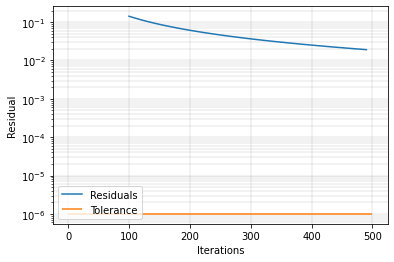

Iteration: 600,	 Residual = 0.00092030793293482042,	 normFactor = 0.00012594325525833142,	 Moving Average = 0.01659273906060150169,	 Time = 0.00000
Iteration: 700,	 Residual = 0.00073461442733843880,	 normFactor = 0.00014059211920936787,	 Moving Average = 0.01303514770511776666,	 Time = 0.00000
Iteration: 800,	 Residual = 0.00059895208604999182,	 normFactor = 0.00015365237744457405,	 Moving Average = 0.01051072212488374930,	 Time = 0.00000
Iteration: 900,	 Residual = 0.00049612207276286343,	 normFactor = 0.00016529248659869422,	 Moving Average = 0.00863570532697545586,	 Time = 0.00000
Iteration: 1000,	 Residual = 0.00041597305533491393,	 normFactor = 0.00017566550589738595,	 Moving Average = 0.00719584411812920245,	 Time = 0.00000


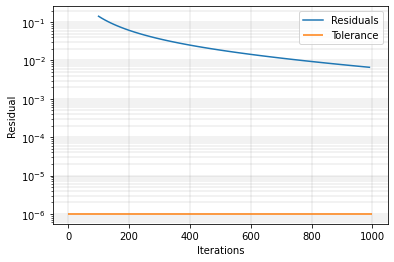

Iteration: 1100,	 Residual = 0.00035213066640982238,	 normFactor = 0.00018490887705063591,	 Moving Average = 0.00606187150849811333,	 Time = 0.00000
Iteration: 1200,	 Residual = 0.00030039106393949769,	 normFactor = 0.00019314544716524050,	 Moving Average = 0.00515103155264688087,	 Time = 0.00000
Iteration: 1300,	 Residual = 0.00025786942684850335,	 normFactor = 0.00020048481606801792,	 Moving Average = 0.00440781821344484945,	 Time = 0.00000
Iteration: 1400,	 Residual = 0.00022251999556225055,	 normFactor = 0.00020702469267943881,	 Moving Average = 0.00379357943091480692,	 Time = 0.00000
Iteration: 1500,	 Residual = 0.00019285148074786208,	 normFactor = 0.00021285215934015799,	 Moving Average = 0.00328055562348266491,	 Time = 0.00000


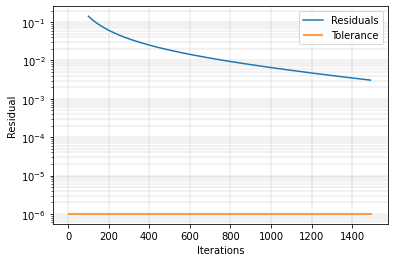

Iteration: 1600,	 Residual = 0.00016775099835396589,	 normFactor = 0.00021804481832493662,	 Moving Average = 0.00284828750153871477,	 Time = 0.00000
Iteration: 1700,	 Residual = 0.00014637114472028056,	 normFactor = 0.00022267182058232984,	 Moving Average = 0.00248136064938575497,	 Time = 0.00000
Iteration: 1800,	 Residual = 0.00012805528601601794,	 normFactor = 0.00022679478495603127,	 Moving Average = 0.00216793942659740781,	 Time = 0.00000
Iteration: 1900,	 Residual = 0.00011228677835096472,	 normFactor = 0.00023046861818078226,	 Moving Average = 0.00189878523149141203,	 Time = 0.00000
Iteration: 2000,	 Residual = 0.00009865362591587876,	 normFactor = 0.00023374224587876876,	 Moving Average = 0.00166658195878363700,	 Time = 0.00000


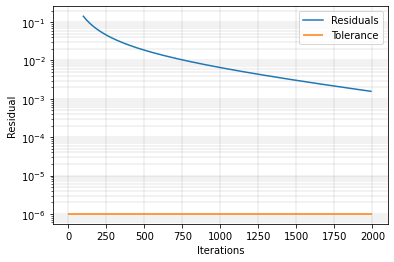

Iteration: 2100,	 Residual = 0.00008682336224335519,	 normFactor = 0.00023665926404179948,	 Moving Average = 0.00146546193991808535,	 Time = 0.00000
Iteration: 2200,	 Residual = 0.00007652485993284986,	 normFactor = 0.00023925851958578770,	 Moving Average = 0.00129066604525074650,	 Time = 0.00000
Iteration: 2300,	 Residual = 0.00006753493414606398,	 normFactor = 0.00024157462767941763,	 Moving Average = 0.00113829558109381835,	 Time = 0.00000
Iteration: 2400,	 Residual = 0.00005966832512728904,	 normFactor = 0.00024363843272263500,	 Moving Average = 0.00100512825026113093,	 Time = 0.00000
Iteration: 2500,	 Residual = 0.00005277010290175641,	 normFactor = 0.00024547741910963325,	 Moving Average = 0.00088847962610193783,	 Time = 0.00000


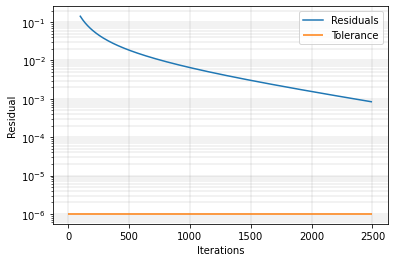

Iteration: 2600,	 Residual = 0.00004670983501766369,	 normFactor = 0.00024711607724887009,	 Moving Average = 0.00078609748713713134,	 Time = 0.00000
Iteration: 2700,	 Residual = 0.00004137705561485601,	 normFactor = 0.00024857622970889137,	 Moving Average = 0.00069608022803357202,	 Time = 0.00000
Iteration: 2800,	 Residual = 0.00003667770744565506,	 normFactor = 0.00024987732183747737,	 Moving Average = 0.00061681314990183857,	 Time = 0.00000
Iteration: 2900,	 Residual = 0.00003253132000602694,	 normFactor = 0.00025103668072214684,	 Moving Average = 0.00054691819345873696,	 Time = 0.00000
Iteration: 3000,	 Residual = 0.00002886875076181679,	 normFactor = 0.00025206974593986234,	 Moving Average = 0.00048521389589940774,	 Time = 0.00000


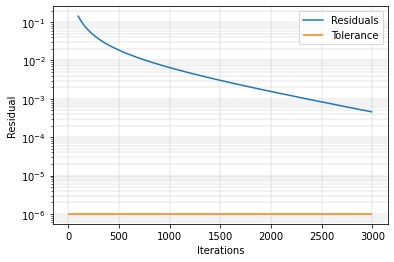

Iteration: 3100,	 Residual = 0.00002563036153696675,	 normFactor = 0.00025299027517230798,	 Moving Average = 0.00043068320649098225,	 Time = 0.00000
Iteration: 3200,	 Residual = 0.00002276453445203057,	 normFactor = 0.00025381052742079317,	 Moving Average = 0.00038244740326368211,	 Time = 0.00000
Iteration: 3300,	 Residual = 0.00002022645518246629,	 normFactor = 0.00025454142626418590,	 Moving Average = 0.00033974479052710678,	 Time = 0.00000
Iteration: 3400,	 Residual = 0.00001797710846878181,	 normFactor = 0.00025519270533119824,	 Moving Average = 0.00030191317552275573,	 Time = 0.00000
Iteration: 3500,	 Residual = 0.00001598244350537114,	 normFactor = 0.00025577303792732739,	 Moving Average = 0.00026837535707335749,	 Time = 0.00000


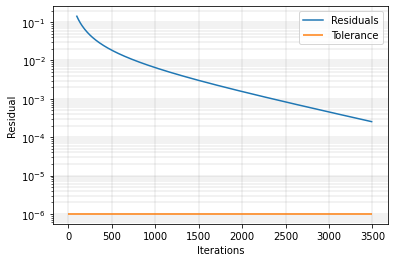

Iteration: 3600,	 Residual = 0.00001421267631141098,	 normFactor = 0.00025629015253910635,	 Moving Average = 0.00023862703350429170,	 Time = 0.00000
Iteration: 3700,	 Residual = 0.00001264170334244895,	 normFactor = 0.00025675093575834422,	 Moving Average = 0.00021222666813041331,	 Time = 0.00000
Iteration: 3800,	 Residual = 0.00001124660608239358,	 normFactor = 0.00025716152399198007,	 Moving Average = 0.00018878694962427513,	 Time = 0.00000
Iteration: 3900,	 Residual = 0.00001000723046486154,	 normFactor = 0.00025752738518368992,	 Moving Average = 0.00016796756043763788,	 Time = 0.00000
Iteration: 4000,	 Residual = 0.00000890582827522565,	 normFactor = 0.00025785339163165283,	 Moving Average = 0.00014946902469439044,	 Time = 0.00000


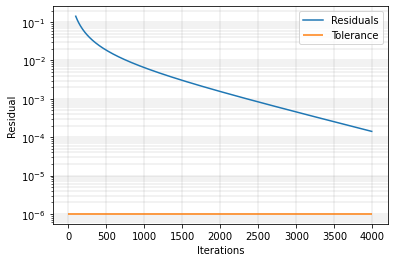

Iteration: 4100,	 Residual = 0.00000792675012825336,	 normFactor = 0.00025814388487442299,	 Moving Average = 0.00013302745215045943,	 Time = 0.00000
Iteration: 4200,	 Residual = 0.00000705618163149864,	 normFactor = 0.00025840273350972298,	 Moving Average = 0.00011841003005259160,	 Time = 0.00000
Iteration: 4300,	 Residual = 0.00000628191587956283,	 normFactor = 0.00025863338471321151,	 Moving Average = 0.00010541114263886999,	 Time = 0.00000
Iteration: 4400,	 Residual = 0.00000559315664256586,	 normFactor = 0.00025883891014527745,	 Moving Average = 0.00009384901977392451,	 Time = 0.00000
Iteration: 4500,	 Residual = 0.00000498034764493674,	 normFactor = 0.00025902204685817286,	 Moving Average = 0.00008356283388223332,	 Time = 0.00000


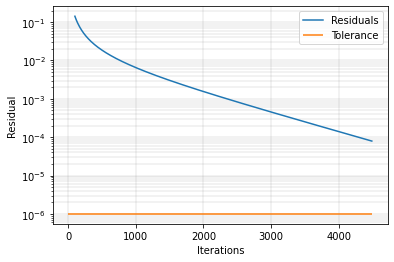

Iteration: 4600,	 Residual = 0.00000443502405373570,	 normFactor = 0.00025918523374590592,	 Moving Average = 0.00007441017823136961,	 Time = 0.00000
Iteration: 4700,	 Residual = 0.00000394968300608151,	 normFactor = 0.00025933064402402557,	 Moving Average = 0.00006626487096877178,	 Time = 0.00000
Iteration: 4800,	 Residual = 0.00000351767046779876,	 normFactor = 0.00025946021417043853,	 Moving Average = 0.00005901503845334591,	 Time = 0.00000
Iteration: 4900,	 Residual = 0.00000313308218191436,	 normFactor = 0.00025957566971526128,	 Moving Average = 0.00005256143887546642,	 Time = 0.00000
Iteration: 5000,	 Residual = 0.00000279067679099823,	 normFactor = 0.00025967854821900204,	 Moving Average = 0.00004681599328406078,	 Time = 0.00000


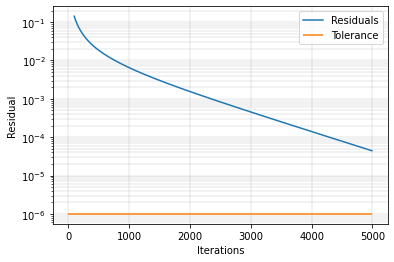

Iteration: 5100,	 Residual = 0.00000248579951108075,	 normFactor = 0.00025977021975016689,	 Moving Average = 0.00004170049613727506,	 Time = 0.00000
Iteration: 5200,	 Residual = 0.00000221431498870505,	 normFactor = 0.00025985190512928989,	 Moving Average = 0.00003714548174338929,	 Time = 0.00000
Iteration: 5300,	 Residual = 0.00000197254814398550,	 normFactor = 0.00025992469218889434,	 Moving Average = 0.00003308922629095032,	 Time = 0.00000
Iteration: 5400,	 Residual = 0.00000175723199589058,	 normFactor = 0.00025998955025885597,	 Moving Average = 0.00002947686818637100,	 Time = 0.00000
Iteration: 5500,	 Residual = 0.00000156546160076147,	 normFactor = 0.00026004734307599639,	 Moving Average = 0.00002625963180590757,	 Time = 0.00000


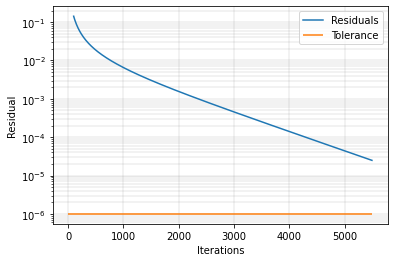

Iteration: 5600,	 Residual = 0.00000139465333419176,	 normFactor = 0.00026009884028696837,	 Moving Average = 0.00002339414176353703,	 Time = 0.00000
Iteration: 5700,	 Residual = 0.00000124250888087235,	 normFactor = 0.00026014472769805353,	 Moving Average = 0.00002084181663523465,	 Time = 0.00000
Iteration: 5800,	 Residual = 0.00000110698335526825,	 normFactor = 0.00026018561640712095,	 Moving Average = 0.00001856833245236473,	 Time = 0.00000

Residuals have converged:

Iteration: 5890,	 Residual = 0.00000099771134389874,	 normFactor = 0.00026021859366451370,	 Moving Average = 0.00001856833245236473,	 Time = 0.00000

Time = 1
mkdir: cannot create directory ‘Solution/1’: File exists

Residuals have converged:

Iteration: 2,	 Residual = 0.00000099540988194802,	 normFactor = 0.00026021928831408735,	 Moving Average = 0.00001856833245236473,	 Time = 1.00000
Run time:  190.3230458140024


In [9]:
# Time loop

import timeit
!rm - r Solution
! mkdir Solution

start = timeit.default_timer()

# Define momentum loop tolerance:
tolerance = 1e-6

# Only allow one time-step if non transient
if not transient:
    t = np.array([0, 1])

# Create A matrices:
A_x = A("x").createMatrix()
A_y = A("y").createMatrix()

for time in t:

    print("\nTime = " + str(round(time, 1)))

    # Reset iteration counter
    icorr = 1

    # Set number of maximum iterations for convergence
    maxcorr = 100000

    # Make directory for timestep
    ! mkdir Solution/{str(round(time, 1))}

    # Initialise arrays for graphs
    residual_array = np.array([])
    moving_average_array = np.array([])
    moving_average_graph_array = np.array([])

    # Add boundary conditions to A matrices

    A_x = boundary_conditions_A(A_x, U_old, U_old_old, "x")
    A_y = boundary_conditions_A(A_y, U_old, U_old_old, "y")

    # Momentum Loop
    while True:

        # Store solution for previous iteration
        U_previous = U_new

        # x-equation
        # Create b matrices
        b_x = boundary_conditions_b(b_x, U_previous, U_old, U_old_old, "x")

        # solve for u
        u = np.linalg.solve(A_x, b_x)
        u = np.array(u)

        # y-equation
        # Create b matrices
        b_y = boundary_conditions_b(b_y, U_previous, U_old, U_old_old, "y")

        # solve for v
        v = np.linalg.solve(A_y, b_y)
        v = np.array(v)

        # Update U_New with new u and v fields
        U_new = np.hstack((u, v))

        # Calculate the residual of each iteration
        normFactor = np.max(U_new + 0.0000000000001)
        residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor

        # Append residual array with residual
        residual_array = np.append(residual_array, residual)

        # The following is for on-going convergence reports:
        # Print out residual every 100 iterations
        if icorr % 100 == 0:
            moving_average = np.mean(
                residual_array[len(residual_array)-100:len(residual_array)])
            moving_average_array = np.append(
                moving_average_array, moving_average)
            print("Iteration: {:01d},\t Residual = {:.20f},\t normFactor = {:.20f},\t Moving Average = {:.20f},\t Time = {:.5f}".format(
                icorr, residual, normFactor, moving_average, time))

        # Calculate moving average of residual
        if icorr % 10 == 0:
            moving_average_graph = np.mean(
                residual_array[len(residual_array)-10:len(residual_array)])
            moving_average_graph_array = np.append(
                moving_average_graph_array, moving_average_graph)

        # Print residual progress every 500 iterations
        if icorr % 500 == 0:

            # plt.plot(np.arange(0, len(residual_array)), residual_array, label = "Residuals")
            plt.plot(np.arange(100, len(moving_average_graph_array)*10, 10),
                     moving_average_graph_array[10:len(moving_average_graph_array)], label="Residuals")
            # plt.scatter((len(moving_average_graph_array)-50)*10, moving_average_graph_array[len(moving_average_graph_array)-50], color = "C1", label  = "Residual 500 iterations ago")
            plt.hlines(tolerance, 0, len(moving_average_graph_array)
                       * 10, color="C1", label="Tolerance")
            plt.yscale("log")
            plt.xlabel("Iterations")
            plt.ylabel("Residual")
            plt.legend()
            plt.grid(True, which="both", ls="-", color="grey", linewidth=0.2)
            plt.show()

        # Convergence check
        if residual < tolerance:

            print("\nResiduals have converged:\n")
            print("Iteration: {:01d},\t Residual = {:.20f},\t normFactor = {:.20f},\t Moving Average = {:.20f},\t Time = {:.5f}".format(
                icorr, residual, normFactor, moving_average, time))

            break

        elif icorr > maxcorr:

            break

        # Increment iteration counter
        icorr = icorr + 1

    # Update displacement temporal fields
    U_old_old = U_old
    U_old = U_new

    # Save displacement field
    saveArray(str(round(time, 1)) + "/U", U_new)

stop = timeit.default_timer()

print('Run time: ', stop - start)


***
[<svg style="color: rgb(53, 145, 243);" xmlns="http://www.w3.org/2000/svg" width="20" height="20" fill="currentColor" class="bi bi-arrow-left-circle-fill" viewBox="0 0 16 16"> <path d="M8 0a8 8 0 1 0 0 16A8 8 0 0 0 8 0zm3.5 7.5a.5.5 0 0 1 0 1H5.707l2.147 2.146a.5.5 
0 0 1-.708.708l-3-3a.5.5 0 0 1 0-.708l3-3a.5.5 0 1 1 .708.708L5.707 7.5H11.5z" fill="#3591f3"></path> </svg> **Notebook 6** ](https://nbviewer.org/github/scottlevie97/pythonFVSolidMechanics/blob/new-release/lesson_notebooks/_06_Solution_Algorithm.ipynb?flush_cache=true)
|
[**Notebook 8** <svg style="color: rgb(53, 145, 243);" xmlns="http://www.w3.org/2000/svg" width="20" height="20" fill="currentColor" class="bi bi-arrow-left-circle-fill" viewBox="0 0 16 16" transform="rotate(180)"> <path d="M8 0a8 8 0 1 0 0 16A8 8 0 0 0 8 0zm3.5 7.5a.5.5 0 0 1 0 1H5.707l2.147 2.146a.5.5 
0 0 1-.708.708l-3-3a.5.5 0 0 1 0-.708l3-3a.5.5 0 1 1 .708.708L5.707 7.5H11.5z" fill="#3591f3"></path> </svg>](https://nbviewer.org/github/scottlevie97/pythonFVSolidMechanics/blob/new-release/lesson_notebooks/_07_Time_Loop.ipynb?flush_cache=true)

***